In [ ]:
! pip install qiskit

In [1]:
! pip install qiskit-aer

In [2]:
! pip install qiskit_machine_learning

     ------------------------------------ 148.7/148.7 kB 982.0 kB/s eta 0:00:00
  Using cached fastdtw-0.3.4.tar.gz (133 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3585 sha256=39ec53a81a2a265c08dd0cfd30f4aca9f6d9284fdcea14f57df0514fe8d6f0f5
  Stored in directory: c:\users\ma548\appdata\local\pip\cache\wheels\b2\b2\20\c0960e8ee3ceaf158c43f28eea50357113dfe2f3106da9fdb1
Successfully built fastdtw


In [3]:
! pip install pylatexenc

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, GradientDescent
from qiskit_machine_learning.algorithms.classifiers import VQC

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

algorithm_globals.random_seed = 42

C:\Users\Ma548\AppData\Local\Temp\ipykernel_14968\457360356.py:7: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, GradientDescent


In [5]:
#holds execution and backend configs
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

C:\Users\Ma548\AppData\Local\Temp\ipykernel_14968\3109454113.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)


## 1. Create simple dataset


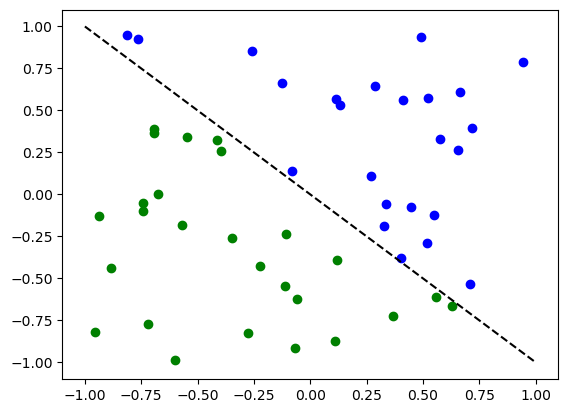

In [6]:
num_inputs = 2
num_samples = 50


X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}

#convert to one hot
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1


for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



In [7]:
X.shape, y_one_hot.shape

((50, 2), (50, 2))

In [8]:
from sklearn.model_selection import train_test_split


x_train,  x_test,  y_train, y_test = train_test_split(X,y_one_hot, test_size=0.2, random_state=45)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((40, 2), (10, 2), (40, 2), (10, 2))

In [9]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()



## 2. Construct Classifier

In [10]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=2)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(), #https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html
    quantum_instance=quantum_instance,
    callback=callback_graph,
)



C:\Users\Ma548\AppData\Local\Temp\ipykernel_14968\4040848750.py:6: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(


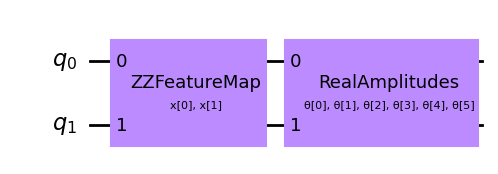

In [11]:
# construct quantum circuit (just for illustration)
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw('mpl')

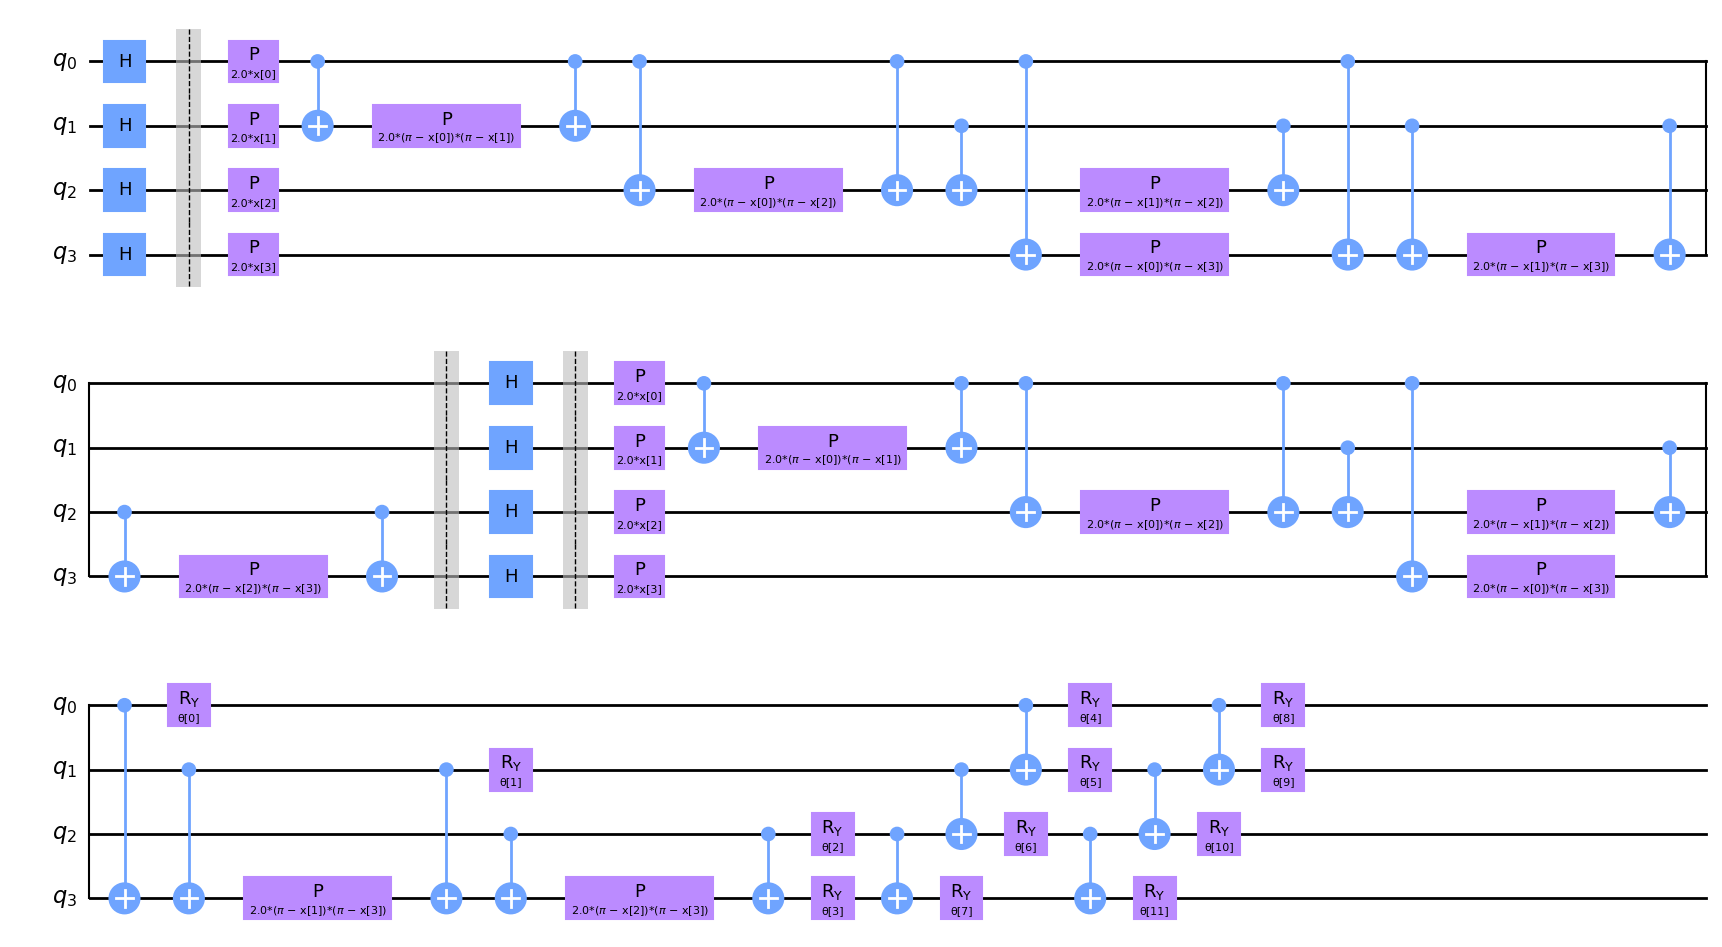

In [12]:

feature_map = ZZFeatureMap(feature_dimension=4, reps=2, insert_barriers=True)
ansatz = RealAmplitudes(4, reps=2)


circuit = feature_map.compose(ansatz) #DEPRECATED - combnine to compose
circuit.decompose().draw(output='mpl')

## 3. Fit Classifier

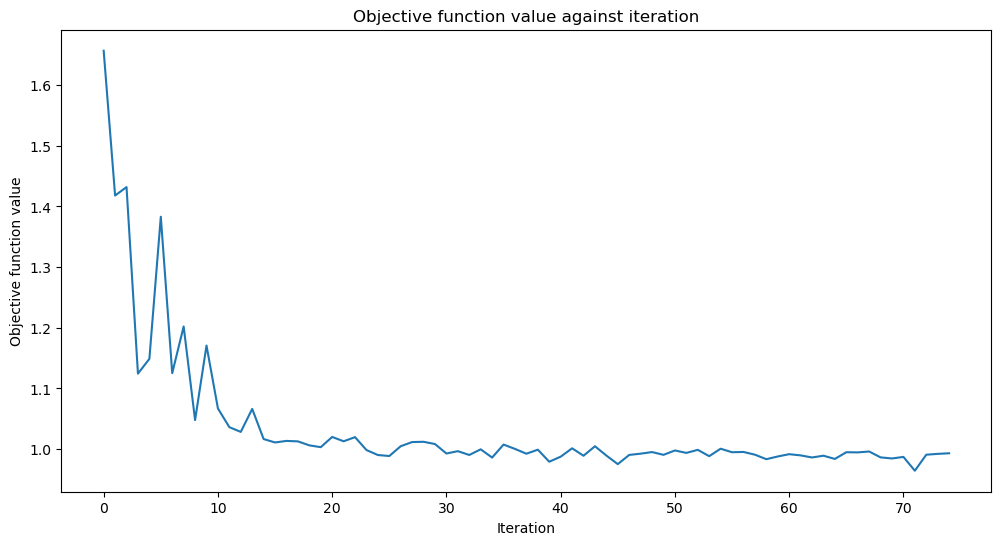

0.6

In [13]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_train, y_train)



## 4. Test


In [14]:
vqc.score(x_test, y_test)


0.3

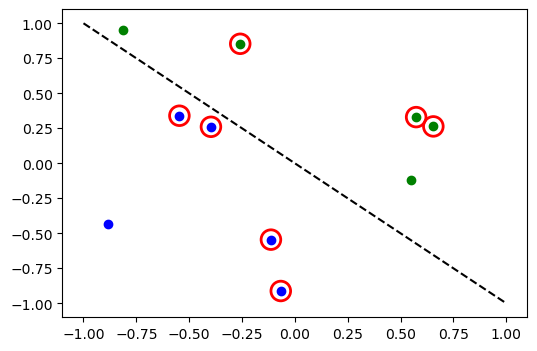

In [15]:
# evaluate data points
y_predict = vqc.predict(x_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(x_test, y_test, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



## IRIS Classification


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris #https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html

In [74]:
x, y = load_iris(as_frame=True, return_X_y=True)

In [75]:
y_onehot = OneHotEncoder().fit_transform(y.values.reshape(-1,1))

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.2)


In [77]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((120, 4), (30, 4), (120, 3), (30, 3))

In [78]:
from sklearn.preprocessing import OneHotEncoder

In [79]:
# y_onehot = OneHotEncoder().fit_transform(y_train.values.reshape(-1,1))

In [80]:
# y_onehot.shape

In [81]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()



In [82]:
# construct feature map, ansatz, and optimizer 
num_inputs = 4
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(), #https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html
    quantum_instance=quantum_instance,
    callback=callback_graph,
)



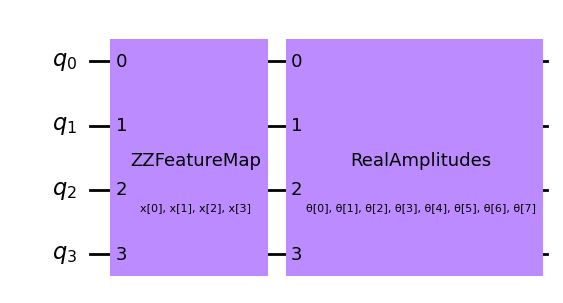

In [83]:
# construct quantum circuit (just for illustration)
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw('mpl')

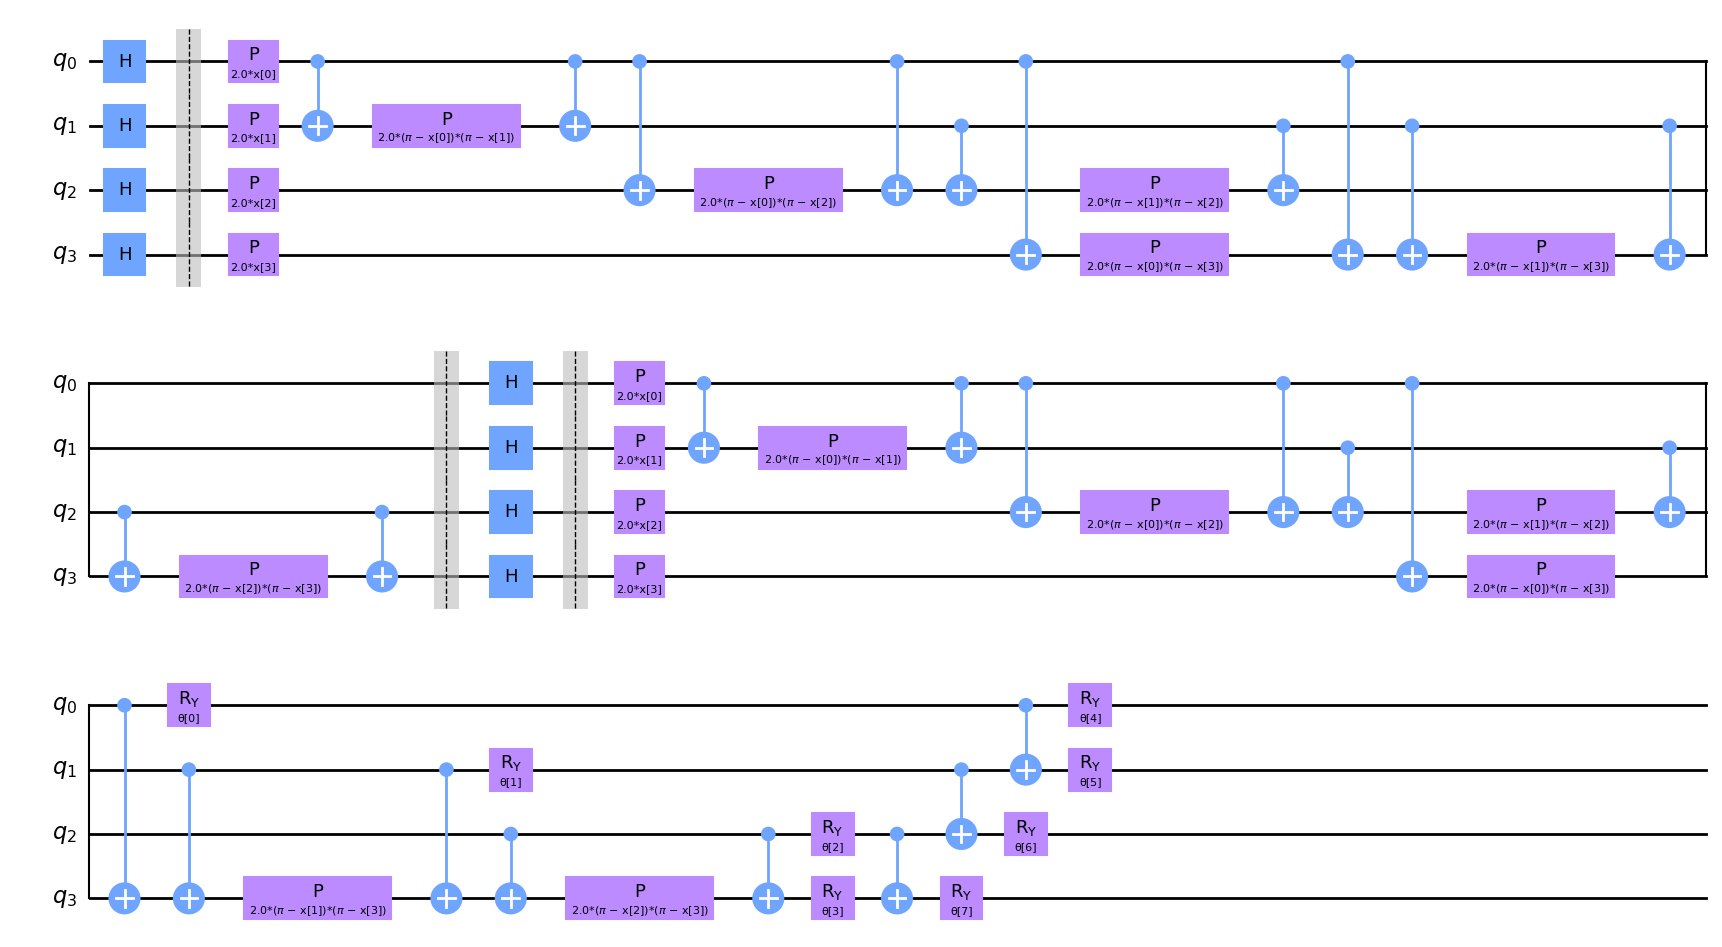

In [84]:

feature_map = ZZFeatureMap(feature_dimension=4, reps=2, insert_barriers=True)
ansatz = RealAmplitudes(4, reps=1)


circuit = feature_map.compose(ansatz) #DEPRECATED - combnine to compose
circuit.decompose().draw(output='mpl')

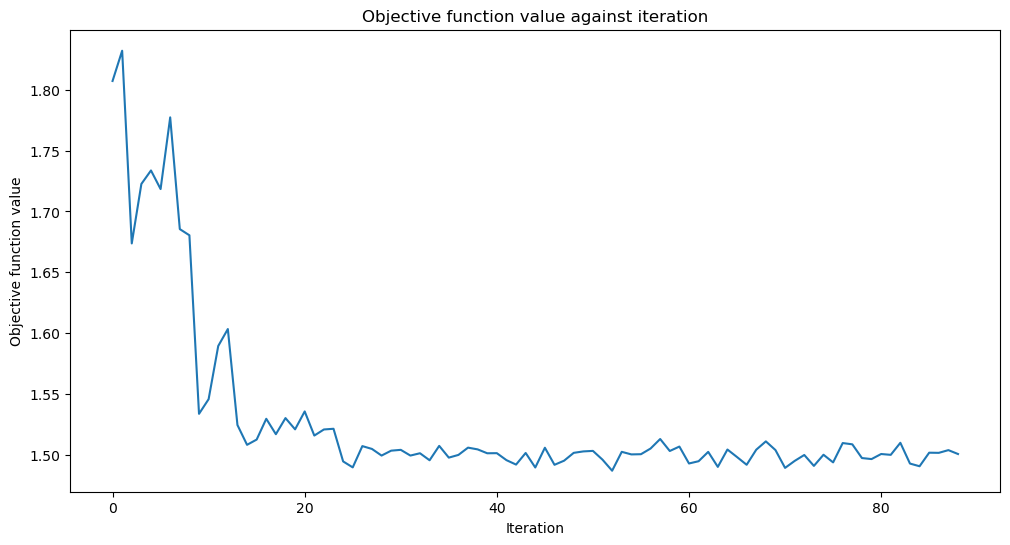

0.425

In [85]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(x_train, y_train)


https://github.com/AbhiSR4/VQC-Qiskit-Fallfest/blob/main/NQSVC.ipynb for more about SVC Quantum Classifier

In [86]:
vqc.score(x_test, y_test)


0.6